# DeepSparse + EfficientNet

This example demonstrates how to use DeepSparse to run a model trained with SparseML and exported to ONNX.

Make sure you have DeepSparse installed:

```bash
pip install deepsparse
```

## Benchmarking

DeepSparse has a friendly benchmarking utility that enables you to quickly experiment with throughput and latency of your model. Run `deepsparse.benchmark --help` to see the full list of scenarios.

In [1]:
!deepsparse.benchmark ./quant-run/torchvision/model.onnx --batch_size 1

2023-04-06 18:52:49 deepsparse.benchmark.benchmark_model INFO     Thread pinning to cores enabled
DeepSparse, Copyright 2021-present / Neuralmagic, Inc. version: 1.4.2 COMMUNITY | (c1765cde) (release) (optimized) (system=avx2, binary=avx2)
2023-04-06 18:52:54 deepsparse.benchmark.benchmark_model INFO     deepsparse.engine.Engine:
	onnx_file_path: ./quant-run/torchvision/model.onnx
	batch_size: 1
	num_cores: 23
	num_streams: 1
	scheduler: Scheduler.default
	fraction_of_supported_ops: 1.0
	cpu_avx_type: avx2
	cpu_vnni: False
2023-04-06 18:52:54 deepsparse.utils.onnx INFO     Generating input 'input', type = float32, shape = [1, 3, 240, 240]
2023-04-06 18:52:54 deepsparse.benchmark.benchmark_model INFO     Starting 'singlestream' performance measurements for 10 seconds
Original Model Path: ./quant-run/torchvision/model.onnx
Batch Size: 1
Scenario: sync
Throughput (items/sec): 201.4600
Latency Mean (ms/batch): 4.9541
Latency Median (ms/batch): 4.9312
Latency Std (ms/batch): 0.2195
Iteratio

## Usage

DeepSparse offers three inference APIs.

- `engine` is the lowest level API. We pass raw tensors and recieve the result of the model. All pre-processing (like normalization) is handled by the user.

- `pipeline` handles pre-processing and postprocessing. We can pass either image files or numpy arrays. Pre-processing (like reformatting the shape, and normalization) is handled by the pipeline.

- `server` is a REST API around `pipeline`.

Here's and example of `engine` and `pipeline`:

## Engine

Run inference on raw tensors, get back full vector of logits.

In [2]:
from deepsparse import Engine
from deepsparse.utils import generate_random_inputs, model_to_path
import numpy as np

path = "./quant-run/torchvision/model.onnx"
batch_size = 1

engine = Engine(
  model=path,   # sparsezoo stub or path to local ONNX
  batch_size=batch_size   # defaults to batch size 1
)

# [array([[-7.73529887e-01,  1.67251182e+00, -1.68212160e-01,
# ....
# 1.26290070e-05, 2.30549040e-06, 2.97072188e-06, 1.90549777e-04]], dtype=float32)]

DeepSparse, Copyright 2021-present / Neuralmagic, Inc. version: 1.4.2 COMMUNITY | (c1765cde) (release) (optimized) (system=avx2, binary=avx2)


In [14]:
# input is raw numpy tensors, output is raw scores for classes
inputs = generate_random_inputs(model_to_path(path), batch_size)
output = engine(inputs)
print(inputs[0].shape)
print(output[0].shape)

2023-04-06 19:03:49 deepsparse.utils.onnx INFO     Generating input 'input', type = float32, shape = [1, 3, 240, 240]


(1, 3, 240, 240)
(1, 102)


## Pipeline

Run inference on unprocessed images, get back post-processed results.

In [4]:
from deepsparse import Pipeline

#### Compile

In [9]:
# download onnx from sparsezoo and compile with batch size 1
path = "./quant-run/torchvision/model.onnx"
batch_size = 1
pipeline = Pipeline.create(
    task="image_classification",
    model_path=path,   # sparsezoo stub or path to local ONNX
    batch_size = batch_size
)

#### Run Inference - Passing a JPEG

In [12]:
# pipeline handles reading from disk and runnning inference
image_path = "./flowers-dataset/val/class_1/img_11.jpg"
prediction = pipeline(images=[image_path])
print(prediction.labels)

[1]


#### Run Inference - Passing a Numpy array

In [13]:
# pass a numpy array
from PIL import Image
import numpy as np

im = Image.open(image_path)
im_np = np.asarray(im)
print(im_np.shape)

# pipeline handles reshaping to 224x224
prediction = pipeline(images=[im_np])
print(prediction.labels)

(667, 500, 3)
[1]


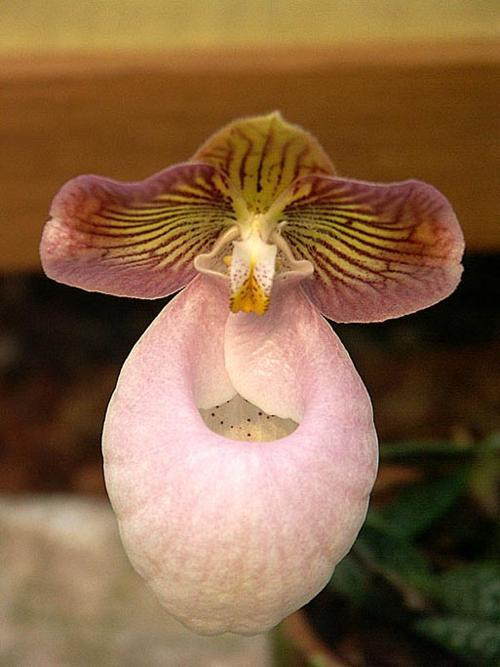

In [16]:
im